# This notebook is a continuation of the classification exercises notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
import acquire
import prepare

# NOTES AND TAKEAWAYS

## Univariate notes
    # Not many senior citizens
    # tenure is like an inverse normals curve. Skewed toward the low and high ends. Those low end values are dragging the avg down a litle
    # a lot of low total charges are draggin down the avg. not normal-->mann whitney test later?
    # none of these features seems very 'normally' distributed, expect to do some hypothesis testing
    # many more "no churn" accounts, so this will be our baseline
    
    #probably some chi2 testing on different categoricals in bivariate analysis. churn/payment type for ex
    #mann whitney for some of those continuos values (monthly and total charges, really)

In [2]:
raw_telco_df = acquire.get_telco_data()
raw_telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [3]:
raw_telco_df.shape

(7043, 24)

In [4]:
raw_telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [5]:
raw_telco_df.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


# I utilized my prep_telco and split_telco_data functions from prepare.py to get the data ready

### Remember how we call functions from file please

In [6]:
# take note of how we had to call the prepare.py file here
telco_prepped = prepare.prep_telco(raw_telco_df)

In [7]:
telco_prepped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            7043 non-null   object 
 1   gender                                 7043 non-null   object 
 2   senior_citizen                         7043 non-null   int64  
 3   partner                                7043 non-null   object 
 4   dependents                             7043 non-null   object 
 5   tenure                                 7043 non-null   int64  
 6   phone_service                          7043 non-null   object 
 7   multiple_lines                         7043 non-null   object 
 8   online_security                        7043 non-null   object 
 9   online_backup                          7043 non-null   object 
 10  device_protection                      7043 non-null   object 
 11  tech

In [8]:
#here, we reassign the three values returned from the split_data function to new variables
telco_train, telco_validate, telco_test = prepare.split_telco_data(telco_prepped)
print(f'telco_train: {telco_train.shape}')
print(f'telco_validate: {telco_validate.shape}')
print(f'telco_test: {telco_test.shape}')

telco_train: (3943, 48)
telco_validate: (1691, 48)
telco_test: (1409, 48)


In [42]:
# telco_train.isnull().sum()
# #great, no null values

In [43]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

telco_X_train = telco_train.drop(columns=['churn_Yes'])
telco_y_train = telco_train.churn_Yes

telco_X_validate = telco_validate.drop(columns=['churn_Yes'])
telco_y_validate = telco_validate.churn_Yes

telco_X_test = telco_test.drop(columns=['churn_Yes'])
telco_y_test = telco_test.churn_Yes

In [44]:
print(f'telco_X_train: {telco_X_train.shape}')
print(f'telco_y_train: {telco_y_train.shape}')


print(f'telco_X_validate: {telco_X_validate.shape}')
print(f'telco_y_validate: {telco_y_validate.shape}')


print(f'telco_X_test: {telco_X_test.shape}')
print(f'telco_y_test: {telco_y_test.shape}')

telco_X_train: (3943, 47)
telco_y_train: (3943,)
telco_X_validate: (1691, 47)
telco_y_validate: (1691,)
telco_X_test: (1409, 47)
telco_y_test: (1409,)


# At this point, we now have our train, validate, test data sets

In [45]:
telco_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 1373 to 518
Data columns (total 47 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            3943 non-null   object 
 1   gender                                 3943 non-null   object 
 2   senior_citizen                         3943 non-null   int64  
 3   partner                                3943 non-null   object 
 4   dependents                             3943 non-null   object 
 5   tenure                                 3943 non-null   int64  
 6   phone_service                          3943 non-null   object 
 7   multiple_lines                         3943 non-null   object 
 8   online_security                        3943 non-null   object 
 9   online_backup                          3943 non-null   object 
 10  device_protection                      3943 non-null   object 
 11  te

In [46]:
telco_X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,3943.0,0.163835,0.370172,0.00,0.000,0.0,0.000,1.00
tenure,3943.0,32.574182,24.628339,0.00,9.000,29.0,56.000,72.00
monthly_charges,3943.0,64.807900,30.189708,18.25,35.175,70.4,89.850,118.65
total_charges,3943.0,2286.089538,2262.429931,0.00,410.575,1417.9,3834.175,8670.10
gender_Male,3943.0,0.505706,0.500031,0.00,0.000,1.0,1.000,1.00
partner_Yes,3943.0,0.484403,0.499820,0.00,0.000,0.0,1.000,1.00
dependents_Yes,3943.0,0.297996,0.457436,0.00,0.000,0.0,1.000,1.00
phone_service_Yes,3943.0,0.908953,0.287713,0.00,1.000,1.0,1.000,1.00
multiple_lines_No phone service,3943.0,0.091047,0.287713,0.00,0.000,0.0,0.000,1.00
multiple_lines_Yes,3943.0,0.425057,0.494414,0.00,0.000,0.0,1.000,1.00


# Univariate analysis:

In [47]:
# this cell is isolating the number format columns for analysis below

num_cols = telco_X_train.columns[[telco_X_train[col].dtype in ('int64', 'float64') for col in telco_X_train.columns]]
num_cols = list(num_cols)
num_cols.append("churn_Yes")

num_cols

['senior_citizen', 'tenure', 'monthly_charges', 'total_charges', 'churn_Yes']

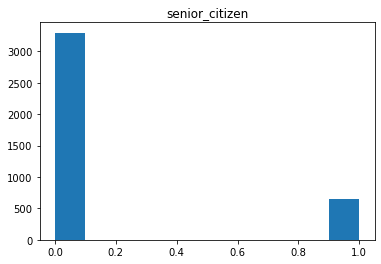

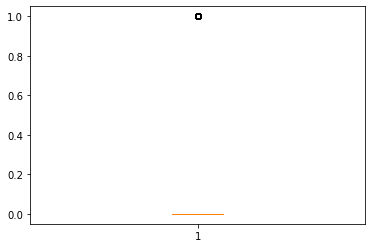

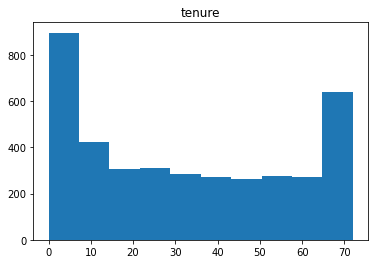

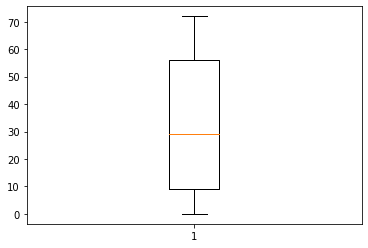

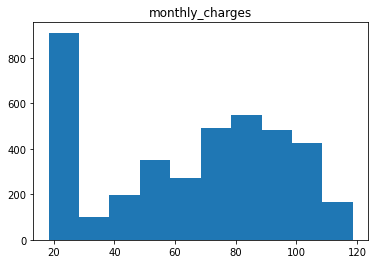

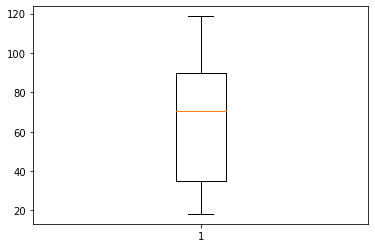

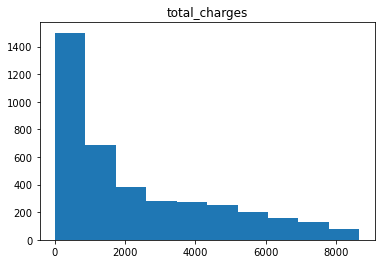

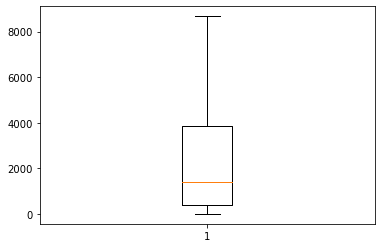

KeyError: 'churn_Yes'

In [48]:
# getting an error now bc i split the churn_Yes feature into the y_train set

# this cell is giving me a histogram and boxplot for all numerical data.  

for col in num_cols:
    plt.hist(telco_X_train[col])
    plt.title(col)
    plt.show()
    plt.boxplot(telco_X_train[col])
    plt.show()
    
# Notes:
# Not many senior citizens
# tenur is like an inverse normals curve. Skewed toward the low and high ends. Those low end values are dragging the avg down a litle
# a lot of low total charges, which are dragging down the avg subustantially
# none of these features seems very 'normally' distributed, expect to do some hypothesis testing

# many more "no churn" accounts, so this will be our baseline

In [22]:
# this cell is isolating the columns with a uint8 type for analysis

# uint_cols = telco_train.columns[[telco_train[col].dtype == 'uint8' for col in telco_train.columns]]
# uint_cols

# ON ADAM'S ADVICE, NOT EXPLORING ENCODED FEATURES

In [23]:
# and here, we get an idea of what each uint8 feature contains

# for col in uint_cols:
#     print(telco_train[col].value_counts())
#     print(telco_train[col].value_counts(normalize = True, dropna=False))
#     print('------------------------')
    
# NOTES
# 51% male
# 51% NO partner
# 70% NO dependents
# 90% YES phone service

# ON ADAM'S ADVICE, I'M NOT GOING TO CONTINUE EXPLORING THE ENCODED FEATURES

In [20]:
# this cell is isolating the columns with an object ('O') type for analysis

obj_cols = telco_train.columns[[telco_train[col].dtype == 'O' for col in telco_train.columns]]
obj_cols

Index(['customer_id', 'gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [21]:
# and here, we get an idea of what each object feature contains

for col in obj_cols:
    print(telco_train[col].value_counts())
    print(telco_train[col].value_counts(normalize = True, dropna=False))
    print('------------------------')
    
# 51% male
# 51% no partner
# 70% no dependents
# 90% phone service
# 48% no multiple lines + 9% no phone svc
# 49% no online security + 22% no internet svc
# 43% no internet svc
# 48% no tech support
# 39% no streaming tv
# 39% no streaming movies
# 59% paperless billing
# 73% churn
# 55% month to month contract
# 43% fiber optic
# 33% elecronic check

7416-CKTEP    1
5649-TJHOV    1
2171-UDMFD    1
9644-UMGQA    1
7969-FFOWG    1
             ..
6797-UCJHZ    1
8200-KLNYW    1
2718-GAXQD    1
5816-QVHRX    1
1212-GLHMD    1
Name: customer_id, Length: 3943, dtype: int64
7416-CKTEP    0.000254
5649-TJHOV    0.000254
2171-UDMFD    0.000254
9644-UMGQA    0.000254
7969-FFOWG    0.000254
                ...   
6797-UCJHZ    0.000254
8200-KLNYW    0.000254
2718-GAXQD    0.000254
5816-QVHRX    0.000254
1212-GLHMD    0.000254
Name: customer_id, Length: 3943, dtype: float64
------------------------
Male      1994
Female    1949
Name: gender, dtype: int64
Male      0.505706
Female    0.494294
Name: gender, dtype: float64
------------------------
No     2033
Yes    1910
Name: partner, dtype: int64
No     0.515597
Yes    0.484403
Name: partner, dtype: float64
------------------------
No     2768
Yes    1175
Name: dependents, dtype: int64
No     0.702004
Yes    0.297996
Name: dependents, dtype: float64
------------------------
Yes    3584
No     

In [24]:
telco_train.monthly_charges.value_counts(bins=5, sort=False)

# lots of monthly charges at the bottom and upper middle

(18.148999999999997, 38.33]    1010
(38.33, 58.41]                  545
(58.41, 78.49]                  762
(78.49, 98.57]                 1033
(98.57, 118.65]                 593
Name: monthly_charges, dtype: int64

In [28]:
telco_train.total_charges.value_counts(bins=5, sort=False)

#again, total charges considerably skewed

(-8.671, 1734.02]     2185
(1734.02, 3468.04]     663
(3468.04, 5202.06]     527
(5202.06, 6936.08]     364
(6936.08, 8670.1]      204
Name: total_charges, dtype: int64

## Bivariate notes



In [39]:
telco_train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
1373,1559-DTODC,Male,0,No,No,19,No,No phone service,No,No,...,0,1,0,0,0,0,0,0,0,0
1034,7100-FQPRV,Male,0,Yes,Yes,43,Yes,Yes,Yes,No,...,1,1,0,1,0,0,0,1,0,0
2722,7036-TYDEC,Female,0,No,No,69,Yes,Yes,No,No,...,1,0,0,0,1,1,0,0,1,0
6867,6469-QJKZW,Female,0,Yes,No,4,Yes,No,No internet service,No internet service,...,0,0,0,0,0,0,1,0,1,0
2805,8984-EYLLL,Male,0,Yes,No,64,Yes,Yes,No,Yes,...,1,1,0,0,1,1,0,0,1,0
